# <center>Итоговый проект "Определение социально уязвимых групп населения" #

 ## Часть 3. Кластеризация. ##

### 3.1 Загрузка и преобразование даных

In [1]:

# загрузим необходимые библиотеки
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from tools.clusters import plot_metrics
from tools.clusters import plot_coef

from sklearn import metrics
from sklearn.metrics import rand_score 
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score



In [2]:
# загрузим датасет с отобранными для анализа признаками
model_df = pd.read_csv(
    '/home/pavel/Work/Skill_Factory_DSPR/GitHub_Projects/Final_Project/Part_2/data/model_df.csv', index_col='region')

In [3]:
# произведем стандартизацию признаков с помощью StandardScaler
stand_scaler = StandardScaler()

scaler_df = stand_scaler.fit_transform(model_df)

scaler_df.shape

(85, 7)

### 3.2. Определение оптимальных параметров и внутренних метрик модели ML.

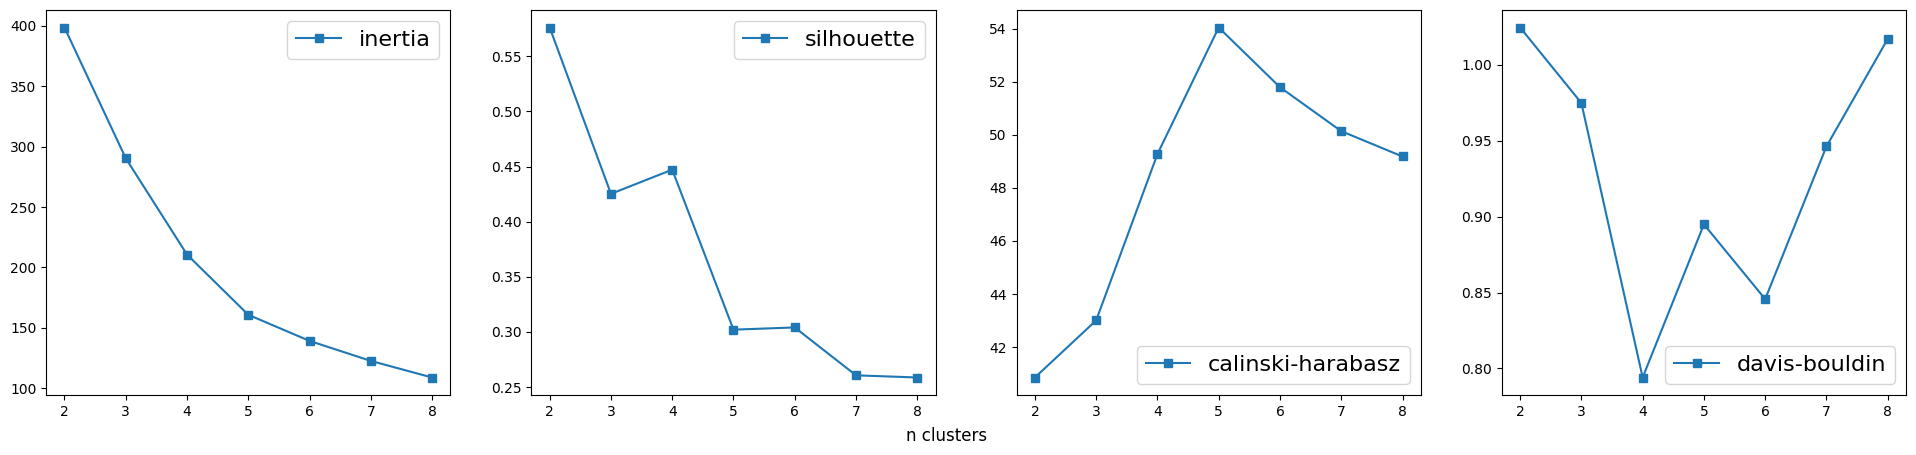

In [4]:
plot_metrics(scaler_df)

"Метод локтя" при оценке инерции, коэффициенты "силуэта" и Дэвиса-Болдина явно указывают на оптимальное колличество кластеров равное 4.Тогда как коэффициент Калински-Харабаса демонстрорует оптималное значение - 5 кластеров. Примем значение числа кластеров равное 4 и при оценке качества модели наибольшее внимание будем уделять  коэффициентам "силуэта" и Дэвиса-Болдина так как они дает более однозначное количество кластеров.

Для сбора метрик моделей проекта в таблицу создадим списки моделей и метрик моделей.

Отобразим проекцию  семимерного признакового пространства  на плоскость используя t-SNE преобразование. Кроме того выведем значения кофициентов "силуэта", Калински-Харабаса и Дэвиса-Болдина для оптимального колличества кластеров - 4. 

Примем модель Kmeans за базовую для сравнения ее с другими моделями кластеризации. Метрикой оценки модели выберем rand_score (Индекс Рэнда рассчитывает меру сходства между двумя кластерингами,рассматривая все пары выборок и подсчитывая пары,которые приписываются одним и тем же или разным кластерам в предсказанных и истинных кластерингах. )

In [5]:
models=[]  # список моделей, которые я буду использовать в этом проекте
silhouette=[] # список коэффициентов "силуэта" моделей
calinski_harabasz=[] # список коэффициентов Калински-Харабаса моделей
davies_bouldin=[] # список коэффициентов Дэвиса_Болдина моделей
rand=[1.0] # список индексов Рэнда( первое значение будет равно 1 т.к. сходство кластеров модели сама с обой равна 1)

def make_metrics_lists(df,labels):    
    coef_silhouette = silhouette_score(df, labels)  
    coef_calinski_harabasz = calinski_harabasz_score(df, labels)  
    coef_davies_bouldin = davies_bouldin_score(df, labels)
    
    silhouette.append(coef_silhouette)
    calinski_harabasz.append(coef_calinski_harabasz)
    davies_bouldin.append(coef_davies_bouldin)

Коэфициент силуэта: 0.447
Коэфициент Калински-Харабаса: 49.273
Коэфициент Дэвиса-Болдина: 0.794


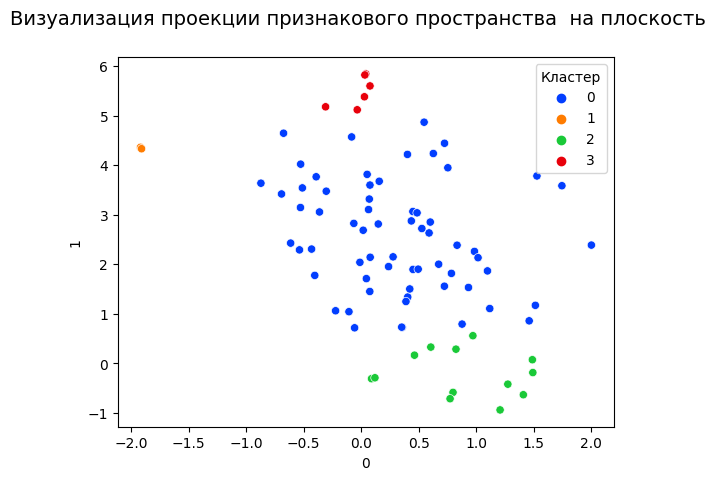

In [6]:
kmeans = KMeans(n_clusters=4, random_state=42)
bm_kmeans = kmeans.fit_predict(scaler_df) # примем модель Kmean за базовую для сравнения с другими

plot_coef(scaler_df, kmeans.labels_)
make_metrics_lists(scaler_df, kmeans.labels_)

models.append(bm_kmeans)

Уменьшим размерность данных методом главных компонент (PCA - principal component analysis). Найдем число главных компонент описывающих 90% дисперсии признакового поля данных. Алгоритм вычисления ***svd_solver*** выберем 'full'

Число главных компонент: 4


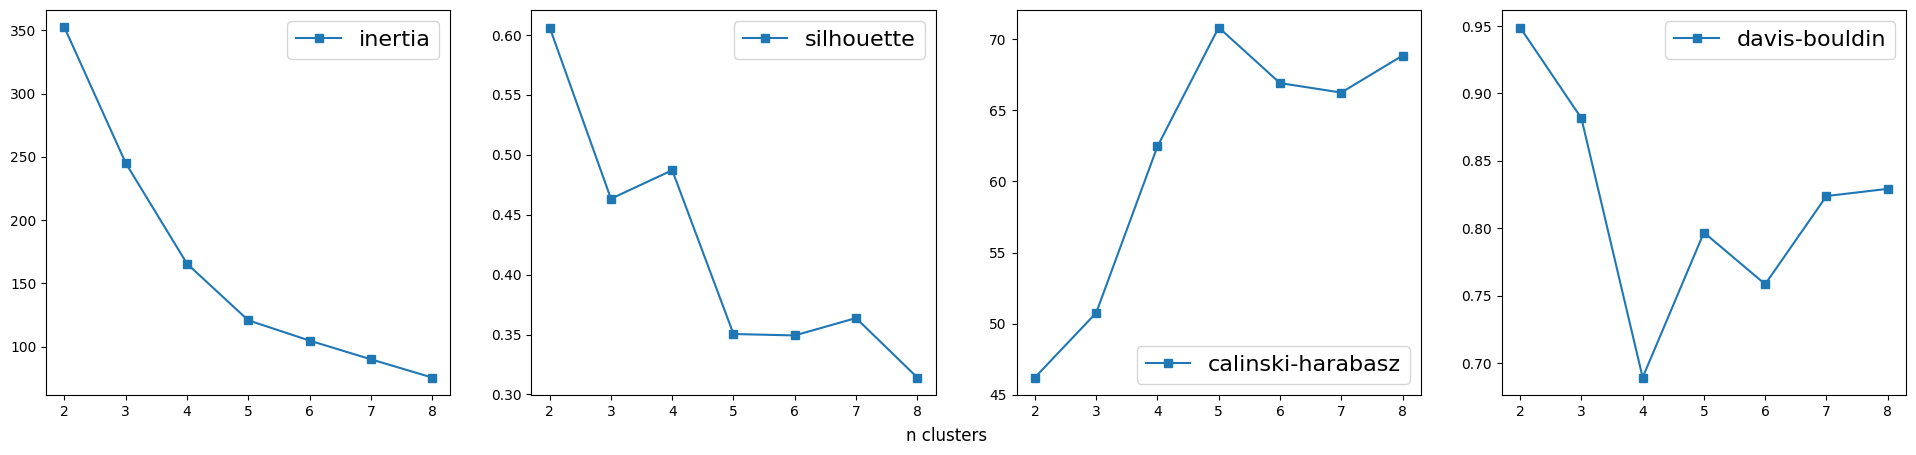

In [7]:
pca = PCA(n_components=0.9, svd_solver='full')
pca_df = pca.fit_transform(scaler_df)

plot_metrics(pca_df)
print(f'Число главных компонент: {pca.n_components_}')

Колличество главных компонент описывающих 90% дисперсии признаков оказалось равным 4. Применение метода главных компонент увеличило величину коэффициентов, но общей картины не изменило. Оствляем колличество кластеров равное 4.

Коэфициент силуэта: 0.487
Коэфициент Калински-Харабаса: 62.463
Коэфициент Дэвиса-Болдина: 0.689
Индекс Рэнда (сравнение с базовой моделью): 1.000


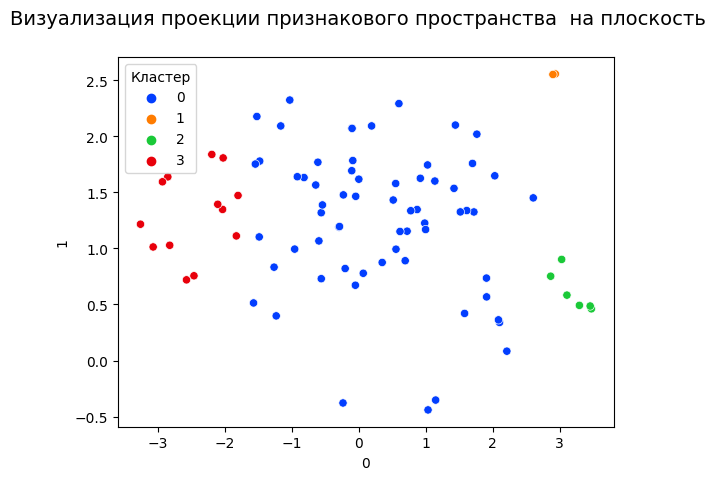

In [8]:
pca_kmeans = KMeans(n_clusters=4, random_state=42)
pca_kmeans.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, pca_kmeans.labels_)

plot_coef(pca_df, pca_kmeans.labels_)
make_metrics_lists(pca_df, pca_kmeans.labels_)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(pca_kmeans)
rand.append(index_rand)

### 3.3. Сравнение с другими алгоритмами кластеризации ###

#### 3.3.1. Спектральная кластеризация

Коэфициент силуэта: 0.540
Коэфициент Калински-Харабаса: 30.169
Коэфициент Дэвиса-Болдина: 0.553
Индекс Рэнда (сравнение с базовой моделью): 0.765


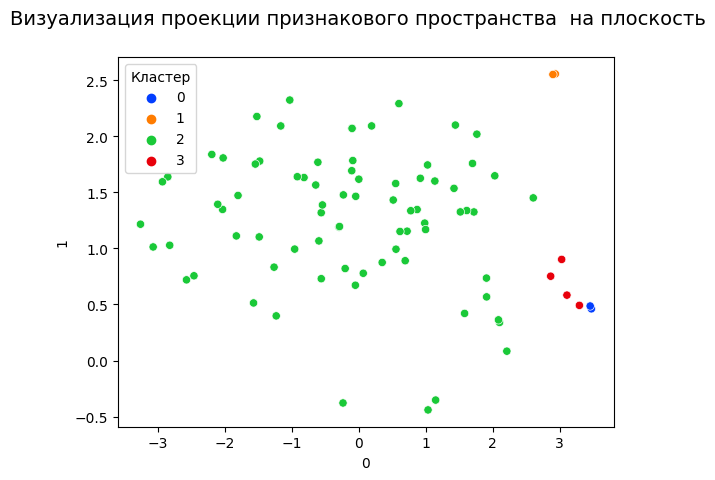

In [9]:
spectral = SpectralClustering(n_clusters=4)
labels = spectral.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, spectral.labels_)

plot_coef(pca_df, spectral.labels_)
make_metrics_lists(pca_df, spectral.labels_)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(spectral)
rand.append(index_rand)

#### 3.3.2. Агломеративная кластеризация

Коэфициент силуэта: 0.551
Коэфициент Калински-Харабаса: 59.192
Коэфициент Дэвиса-Болдина: 0.648
Индекс Рэнда (сравнение с базовой моделью): 0.863


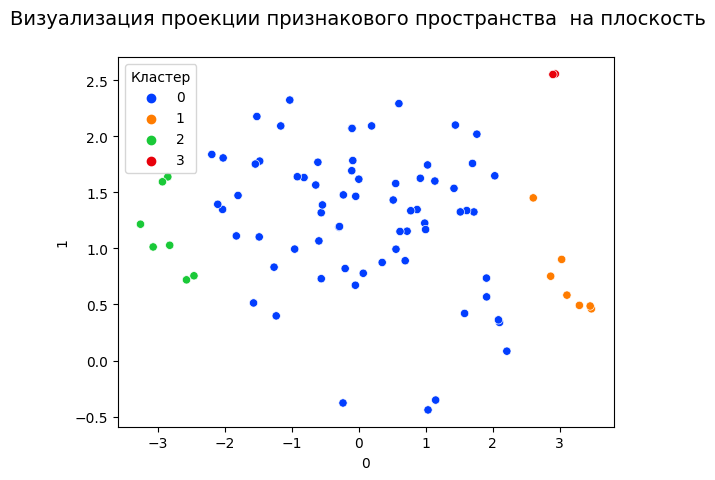

In [10]:
# наилучший вариант: linkage='ward'
agg_clust= AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = agg_clust.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, agg_clust.labels_)

plot_coef(pca_df, agg_clust.labels_)
make_metrics_lists(pca_df, agg_clust.labels_)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(agg_clust)
rand.append(index_rand)

#### 3.3.3. Гауссова смесь

Коэфициент силуэта: 0.558
Коэфициент Калински-Харабаса: 51.665
Коэфициент Дэвиса-Болдина: 0.573
Индекс Рэнда (сравнение с базовой моделью): 0.821


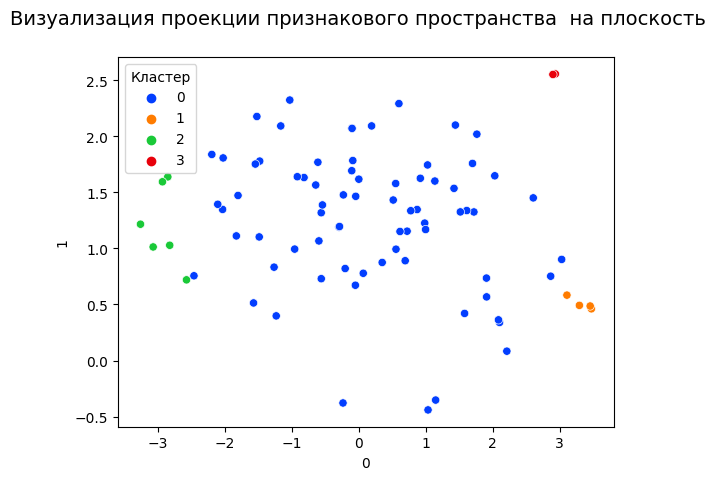

In [11]:
gaus_mix = GaussianMixture(
    n_components=4,
    random_state=42,
    covariance_type='tied'
)
labels = gaus_mix.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, labels)

plot_coef(pca_df, labels)
make_metrics_lists(pca_df, labels)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(agg_clust)
rand.append(index_rand)

#### 3.3.4. Итоговая таблица метрик.

Построим для наглядности итоговую таблицу метрик:

In [12]:
d = {'model':['Base Kmeans','Kmeans+PSA', 'SpectralClustering+PCA',
              'AgglomerativeClustering+PCA', 'GaussianMixture+PCA'], 
                                          'Коэф."силуэта"': silhouette,
                                          'Коэф. Калински-Харабаса':calinski_harabasz,
                                          'Коэф. Дэвис-Болдина':davies_bouldin,
                                          'Индекс Рэнда':rand}
metrics_table = pd.DataFrame.from_dict(d, orient='index').T 
metrics_table

,model,"Коэф.""силуэта""",Коэф. Калински-Харабаса,Коэф. Дэвис-Болдина,Индекс Рэнда
0,Base Kmeans,0.447183,49.272821,0.794037,1.0
1,Kmeans+PSA,0.487164,62.462685,0.689375,1.0
2,SpectralClustering+PCA,0.539953,30.168859,0.553299,0.764706
3,AgglomerativeClustering+PCA,0.550925,59.19151,0.648294,0.863025
4,GaussianMixture+PCA,0.557829,51.665114,0.572823,0.820728


В совокупности метрик кластеризации наилучший результат дает Агломеративноая кластеризация с примененным методом главных компонент. Значение коэффициента "силуэта" достаточно большое среди наибольших значений (0.55), коэффициент Калински-Харабаса один из наибольших, коэфицциент Дэвиса-Болдина имеет близкое к среднему значение.

#### 3.3.5. Сохранение модели кластеризации и датафрейма с метками кластеров. ####

In [13]:
 '''В моделе применим следующие этапы:
        - StandardScaler: стандартизация признакового поля данных;
        - PCA: понижение размерности методом главных компонент с сохранением дисперсии признаков 90%;
        - SpectralClustering: спектральная кластеризация.
'''
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.9, svd_solver='full')), ('agg_clust', AgglomerativeClustering(n_clusters=4))])

# сохраним модель в виде pickle-файла
with open('tools/model.pkl', 'wb') as n:
    pickle.dump(pipe, n)
    
#
agg_clust= AgglomerativeClustering(n_clusters=4, linkage='ward')
model_df['cluster'] = agg_clust.fit_predict(pca_df) # метки кластеров

# упорядочим нумерацию кластеров по колличеству регионов
model_df['cluster'] = model_df['cluster'].replace({0:0, 2:1, 1:2, 3:3})

# сохраним датафрейм с метками кластеров
model_df['cluster'].to_csv('./data/labels.csv')

# сохраним метки кластеров
model_df.to_csv('./data/df_labels.csv')

### <center> 4. Характеристика полученных кластеров

In [14]:
model_df.head(3)

,density,per_capita,gdpp,welfare,retail,poverty_percent,unemployment_rate,cluster
region,,,,,,,,
Алтайский край,13.792906,23864,291156.9,29.7,153605,17.5,5.9,0
Амурская область,2.182997,35499,571362.1,21.7,245233,15.2,6.0,0
Архангельская область без Ненецкого АО,2.644435,34852,514200.4,21.4,250033,12.3,7.4,0


In [15]:
model_df['cluster'].value_counts().sort_index()

0    69
1     7
2     7
3     2
Name: cluster, dtype: int64

In [16]:
# 0 Кластер

cluster_0 = list(model_df[model_df['cluster'] == 0].index)
print (', '.join(cluster_0))


Алтайский край, Амурская область, Архангельская область без Ненецкого АО, Астраханская область, Белгородская область, Брянская область, Владимирская область, Волгоградская область, Вологодская область, Воронежская область, Еврейская автономная область, Забайкальский край, Ивановская область, Иркутская область, Калининградская область, Калужская область, Камчатский край, Кемеровская область, Кировская область, Костромская область, Краснодарский край, Красноярский край, Курганская область, Курская область, Ленинградская область, Липецкая область, Мурманская область, Нижегородская область, Новгородская область, Новосибирская область, Омская область, Оренбургская область, Орловская область, Пензенская область, Пермский край, Приморский край, Псковская область, Республика Адыгея, Республика Башкортостан, Республика Бурятия, Республика Дагестан, Республика Карелия, Республика Коми, Республика Крым, Республика Марий Эл, Республика Мордовия, Республика Саха (Якутия), Республика Северная Осетия

In [17]:
model_df[model_df['cluster'] == 0].describe()

,density,per_capita,gdpp,welfare,retail,poverty_percent,unemployment_rate,cluster
count,69.000000,69.000000,6.900000e+01,69.000000,69.000000,69.000000,69.000000,69.0
mean,34.366454,29575.014493,4.803316e+05,23.462319,197743.608696,13.588406,6.363768,0.0
std,63.189366,6162.649987,1.847887e+05,4.115898,36223.836797,3.288641,2.184502,0.0
min,0.315223,20631.000000,2.396407e+05,12.600000,127327.000000,6.600000,3.600000,0.0
25%,10.487331,25449.000000,3.584804e+05,22.400000,168066.000000,11.900000,5.000000,0.0
50%,23.922313,28152.000000,4.596295e+05,23.500000,196888.000000,13.500000,5.900000,0.0
75%,41.800820,32226.000000,5.419302e+05,25.700000,226691.000000,15.200000,7.300000,0.0
max,519.835648,55373.000000,1.168152e+06,31.400000,277942.000000,23.600000,15.700000,0.0


In [18]:
# 1 Кластер

cluster_1 = list(model_df[model_df['cluster'] == 1].index)
print (', '.join(cluster_1))

Кабардино-Балкарская Республика, Карачаево-Черкесская Республика, Республика Алтай, Республика Ингушетия, Республика Калмыкия, Республика Тыва, Чеченская Республика


In [19]:
model_df[model_df['cluster'] == 1].describe()

,density,per_capita,gdpp,welfare,retail,poverty_percent,unemployment_rate,cluster
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0
mean,51.998338,20405.571429,230222.742857,28.057143,101561.857143,25.142857,17.100000,1.0
std,60.182692,2535.225556,69051.905900,5.950030,36976.663489,4.113335,6.398177,0.0
min,1.941727,16877.000000,142199.700000,19.800000,50713.000000,20.400000,9.600000,1.0
25%,2.999078,18960.500000,189250.500000,24.050000,80218.000000,22.950000,14.400000,1.0
50%,32.606850,19811.000000,210674.100000,26.500000,86002.000000,23.800000,14.800000,1.0
75%,80.539101,21817.000000,267625.650000,33.450000,129653.000000,27.100000,18.250000,1.0
max,162.363433,24596.000000,344933.100000,35.100000,154476.000000,31.700000,30.000000,1.0


In [20]:
# 2 Кластер

cluster_2 = list(model_df[model_df['cluster'] == 2].index)
print (', '.join(cluster_2))

Магаданская область, Московская область, Ненецкий автономный округ, Сахалинская область, Ханты-Мансийский автономный округ - Югра, Чукотский автономный округ, Ямало-Ненецкий автономный округ


In [21]:
model_df[model_df['cluster'] == 2].describe()

,density,per_capita,gdpp,welfare,retail,poverty_percent,unemployment_rate,cluster
count,7.000000,7.000000,7.000000e+00,7.000000,7.000000,7.000000,7.000000,7.0
mean,26.223158,70962.714286,2.779390e+06,13.742857,270956.571429,7.685714,4.771429,2.0
std,64.972879,17452.179918,1.701409e+06,4.212623,52013.874838,1.510440,2.156165,0.0
min,0.069701,47046.000000,6.838451e+05,6.400000,217089.000000,4.800000,2.400000,2.0
25%,0.276265,57606.500000,2.014819e+06,11.850000,236011.500000,7.250000,3.300000,2.0
50%,0.707760,70864.000000,2.059206e+06,14.400000,258117.000000,8.000000,4.400000,2.0
75%,4.368521,86844.000000,3.738377e+06,16.150000,300950.500000,8.550000,5.600000,2.0
max,173.495071,89928.000000,5.206287e+06,19.400000,347566.000000,9.400000,8.800000,2.0


In [22]:
# 3 Кластер

cluster_3 = list(model_df[model_df['cluster'] == 3].index)
print (', '.join(cluster_3))

Москва, Санкт-Петербург


In [23]:
model_df[model_df['cluster'] == 3].describe()

,density,per_capita,gdpp,welfare,retail,poverty_percent,unemployment_rate,cluster
count,2.000000,2.000000,2.000000e+00,2.000000,2.000000,2.000000,2.000000,2.0
mean,4398.978084,63245.000000,1.269401e+06,18.650000,346084.000000,5.950000,2.750000,3.0
std,779.886114,19852.729989,4.217799e+05,1.626346,88515.626869,0.070711,0.212132,0.0
min,3847.515324,49207.000000,9.711580e+05,17.500000,283494.000000,5.900000,2.600000,3.0
25%,4123.246704,56226.000000,1.120280e+06,18.075000,314789.000000,5.925000,2.675000,3.0
50%,4398.978084,63245.000000,1.269401e+06,18.650000,346084.000000,5.950000,2.750000,3.0
75%,4674.709464,70264.000000,1.418523e+06,19.225000,377379.000000,5.975000,2.825000,3.0
max,4950.440843,77283.000000,1.567645e+06,19.800000,408674.000000,6.000000,2.900000,3.0


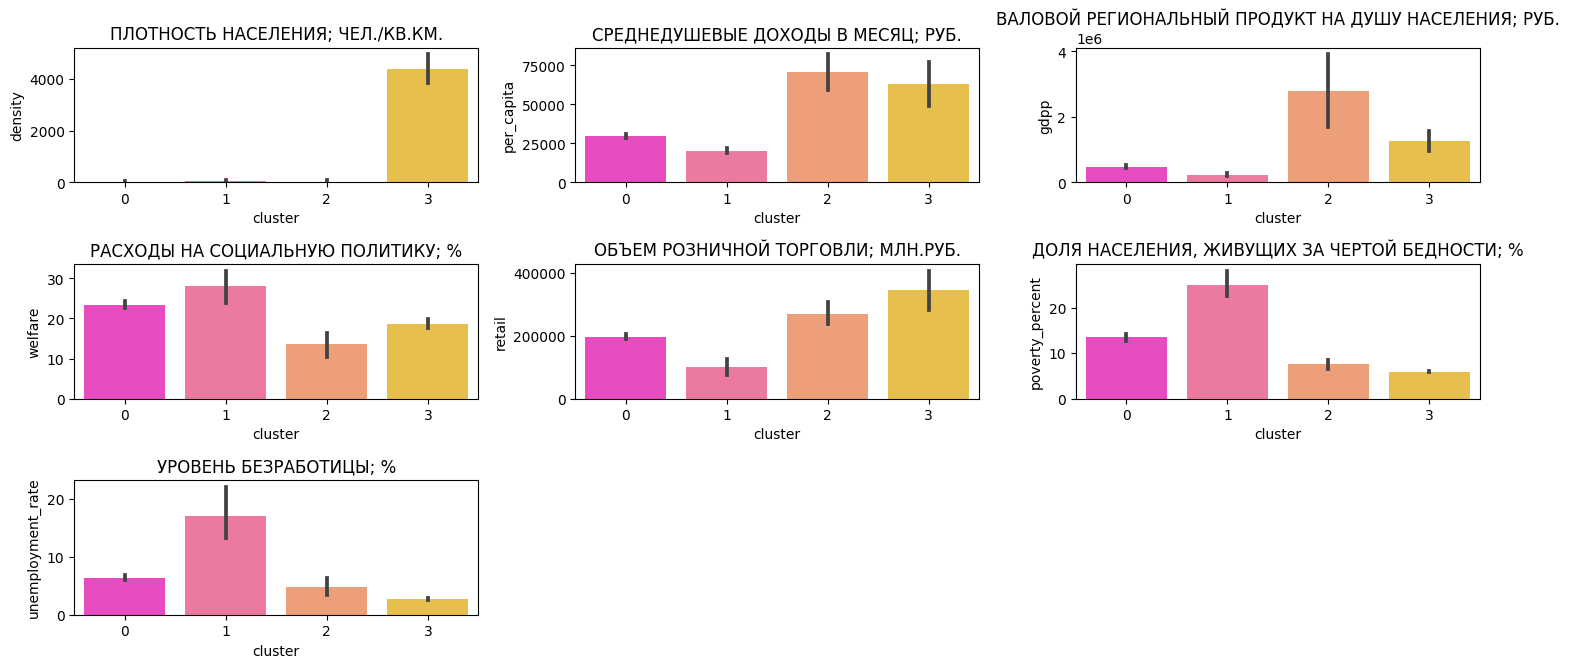

In [24]:
title=['Плотность населения; чел./кв.км.','Среднедушевые доходы в месяц; руб.',
       'Валовой региональный продукт на душу населения; руб.','Расходы на социальную политику; %',
       'Объем розничной торговли; млн.руб.','Доля населения, живущих за чертой бедности; %',
       'Уровень безработицы; %']

cols = model_df[
    [
        'density',
        'per_capita',
        'gdpp',
        'welfare',
        'retail',
        'poverty_percent',
        'unemployment_rate'        
    ]
].columns.tolist()
plt.figure(figsize=(15, 15))

for i, variable in enumerate(cols):
    plt.subplot(7, 3, i + 1)
    sns.barplot(model_df['cluster'], model_df[variable], palette="spring")
    plt.tight_layout()
    plt.title(title[i].upper())
plt.show()

Проанализировав статистические характеристики кластеров, сравнив их между собой и для наглядности отобразив их в виде столбчатых диагарамм можно дать следующую характеристику кластерам:

 * ***кластер_0*** - самый большой по колличеству субъектов (69), с низкой плотностью населения (34,4 чел./кв.км.)характерной для большинства субъектов РФ, достаточными средними показателями дохода, валового регионального продукта, объема розничной торговли на душу населения, большой долей населения живущего за чертой бедности, но и, большими расходами на социальную политику, достаточно низким уровенем безработицы (6,4% населения);

 * ***кластер_1*** - колличество субъектов - 7, с плотностью населения (52 чел./кв.км.), самыми низкими с другими кластерами средними показателями дохода, валового регионального продукта, объема розничной торговли на душу населения, очень большой долей населения живущего за чертой бедности, но и, очень большими расходами на социальную политику и самым высоким уровенем безработицы (17,1% населения);

 * ***кластер_2*** - колличество субъектов - 7, с плотностью населения (26,2 чел./кв.км.), с самыми высокими средними показателями дохода, валового регионального продукта на душу населения, высоким средним показателем объема розничной торговли, небольшой долей населения живущего за чертой бедности, не очень большими расходами на социальную политику и не большим уровенем безработицы (4,8 % населения);

 * ***кластер_3*** - колличество субъектов - 2 (города федерального значения Москва и Санкт-Петербург), с плотностью населения ( 4399 чел./кв.км. !), с высокими средними показателями дохода, валового регионального продукта на душу населения, самым высоким средним показателем объема розничной торговли, минимальной долей населения живущего за чертой бедности,  большими расходами на социальную политику и минимальным уровенем безработицы (2,8 % населения).

Исходя из характеристики кластеров можно принять разделение регионов по уровню социальной защищенности:

   * ***кластер_0*** - субъекты со средним уровнем;

   * ***кластер_1*** - субъекты с низким уровнем;

   * ***кластер_2*** - субъекты с высоким уровнем;

   * ***кластер_3*** - субъекты с очень высоким уровнем.


Загрузим датафрейм с 27 признаками, присвоим регионам метки кластеров и сравним значения некоторых признаков между кластерами: 




In [25]:
#  загрузим данные проекта в df
df = pd.read_csv(
    '/home/pavel/Work/Skill_Factory_DSPR/GitHub_Projects/Final_Project/Part_1/data/sp_df_2020.csv', index_col='region')

df['cluster'] = model_df['cluster']
df.head(3)



,population,area,living area,bad conditions,no funds,per_capita,real_incomes,formal_wage,real_pay,gdpp,...,newborn,child_mortality_rural,child_mortality_urban,morbidity,respiratory,neoplasms,disabled,density,spec_reg_prod,cluster
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,2317153,167996,18.0,0.3,0.8642,23864,95.5,30072,103.8,291156.9,...,19976,44,53,335066,57.302,10.293,168269.0,13.792906,367.883929,0
Амурская область,790044,361908,17.3,1.3,1.0731,35499,100.3,52430,105.2,571362.1,...,7853,13,29,164545,30.788,3.568,62621.0,2.182997,512.093588,0
Архангельская область без Ненецкого АО,1092424,413103,16.9,1.4,1.2998,34852,98.4,52779,102.9,514200.4,...,8906,5,24,565545,88.038,16.234,42970.0,2.644435,607.920547,0


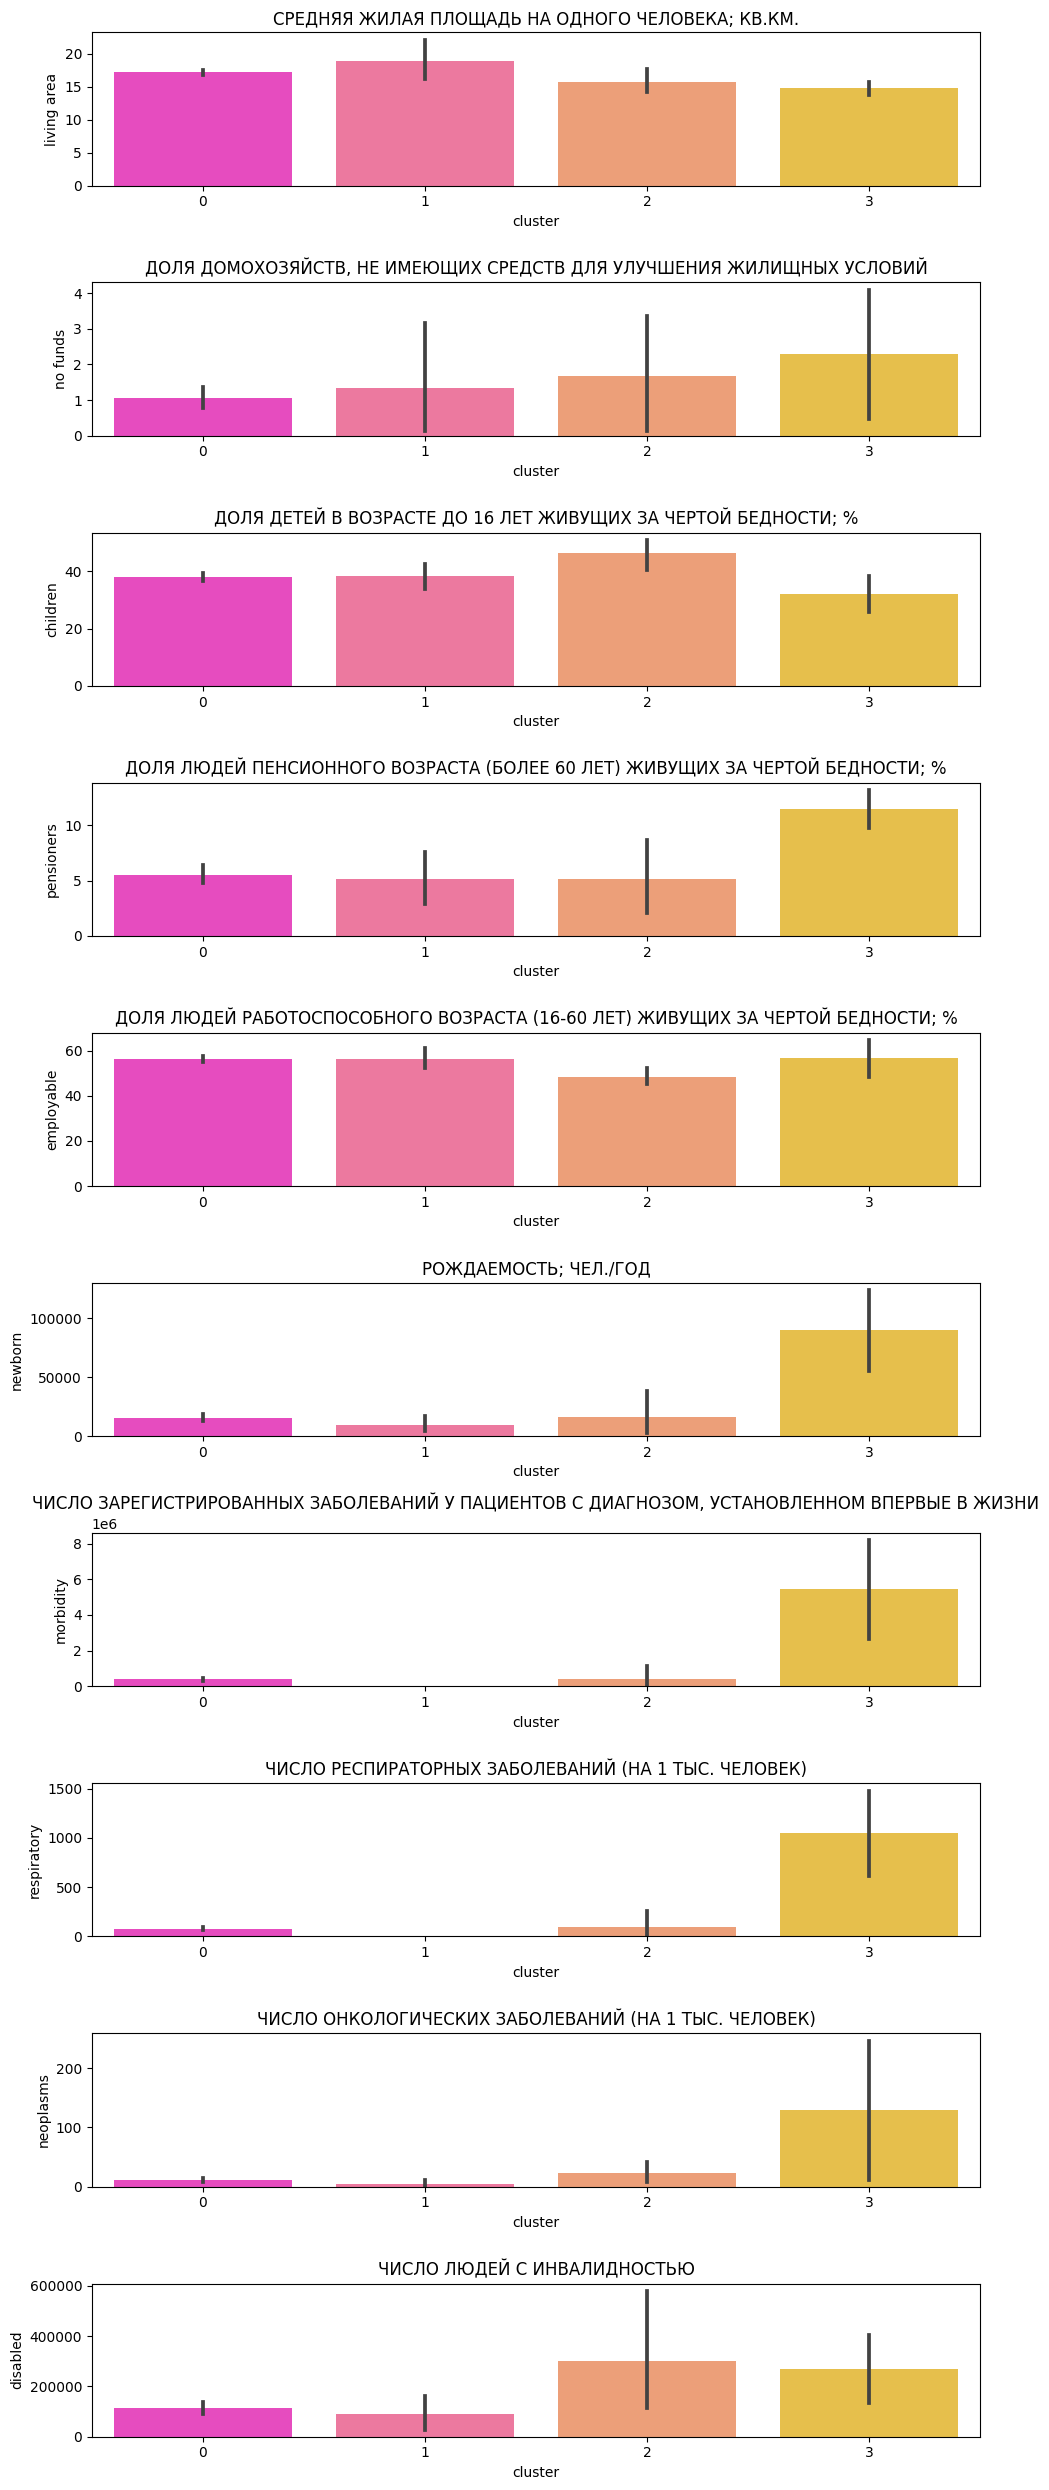

In [28]:
# построим столбчатые диаграмы признаков сгруппированных по кластерам

title=['Средняя жилая площадь на одного человека; кв.км.',
       'Доля домохозяйств, не имеющих средств для улучшения жилищных условий',
       'Доля детей в возрасте до 16 лет живущих за чертой бедности; %',
       'Доля людей пенсионного возраста (более 60 лет) живущих за чертой бедности; %',
       'Доля людей работоспособного возраста (16-60 лет) живущих за чертой бедности; %',
       'Рождаемость; чел./год',
       'число зарегистрированных заболеваний у пациентов с диагнозом, установленном впервые в жизни',
       'число респираторных заболеваний (на 1 тыс. человек)',
       'число онкологических заболеваний (на 1 тыс. человек)',
       'число людей с инвалидностью']

cols = df[
    [
        'living area',
        'no funds',
        'children',
        'pensioners',
        'employable',
        'newborn',
        'morbidity',
        'respiratory',
        'neoplasms',
        'disabled'       
    ]
].columns.tolist()
plt.figure(figsize=(10, 25))

for i, variable in enumerate(cols):
    plt.subplot(10, 1, i + 1)
    sns.barplot(df['cluster'], df[variable], palette="spring")
    plt.tight_layout()
    plt.title(title[i].upper())
plt.show()